In [89]:
%load_ext autoreload
%autoreload 2
%load_ext rich
from torchvision.models import resnet50, ResNet50_Weights
from dutils.w4c_dataloader import RainData
from dutils.data_utils import load_config
from meteopress.models.unet_attention.model import UNet_Attention
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from models.models import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [3]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Sequential()

In [336]:
class ResNetEmbedder(nn.Module):
    def __init__(self):
        super(ResNetEmbedder, self).__init__()

        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = None
        self.backbone.avgpool = None

        self.avg_pool = nn.AvgPool3d(kernel_size=9, stride=1)
        self.max_pool = nn.AvgPool3d(kernel_size=9, stride=1)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.resize232 = T.Resize((232, 232))

    def forward(self, x):
        x = x.swapaxes(1, 2)
        pre_shape = x.shape[:2]
        avg_pooled = self.avg_pool(x)
        max_pooled = self.max_pool(x)
        avg_resized = self.resize232(avg_pooled.flatten(1, 2))
        max_resized = self.resize232(max_pooled.flatten(1, 2))
        avg_reshaped = avg_resized.reshape((*list(pre_shape), 3, 232, 232))
        max_reshaped = max_resized.reshape((*list(pre_shape), 3, 232, 232))
        concat = torch.cat([max_reshaped, avg_reshaped], dim=1).squeeze(0)
        
        x = self.backbone.conv1(concat)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.adaptive_avg_pool(x).reshape((*list(pre_shape), 1, 256, 256))

        return x


In [5]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

In [6]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self, params: dict, training_params: dict, mode: str):
        super().__init__()
        self.params = params
        self.training_params = training_params
        if mode in ['train']:
            self.train_ds = RainData('training', **self.params)
            self.val_ds = RainData('validation', **self.params)
        if mode in ['val']:
            self.val_ds = RainData('validation', **self.params)
        if mode in ['predict']:
            self.test_ds = RainData('test', **self.params)

    def __load_dataloader(self, dataset, shuffle=True, pin=True):
        dl = DataLoader(dataset,
                        batch_size=8,
                        num_workers=0,
                        shuffle=shuffle, pin_memory=pin, prefetch_factor=2,
                        persistent_workers=False)
        return dl

    def train_dataloader(self) -> DataLoader:
        return self.__load_dataloader(self.train_ds, shuffle=True, pin=True)

    def val_dataloader(self) -> DataLoader:
        return self.__load_dataloader(self.val_ds, shuffle=False, pin=True)

    def test_dataloader(self) -> DataLoader:
        return self.__load_dataloader(self.test_ds, shuffle=False, pin=True)

In [9]:
params_ensemble = load_config("models/configurations/config_ensemble.yaml")

In [10]:
data = DataModule(params_ensemble['dataset'], params_ensemble['train'], 'train')

In [318]:
x = torch.Tensor(data.train_dataloader().dataset[0][0]).unsqueeze(0)

In [115]:
x.shape

torch.Size([1, 11, 4, 252, 252])

In [14]:
resize = T.Resize((232, 232))

In [21]:
torch.reshape(resize(x.flatten(1, 2)), (1, 11, 4, 232, 232)).shape

torch.Size([1, 11, 4, 232, 232])

In [49]:
x.swapaxes(1, 2).shape

torch.Size([1, 4, 11, 252, 252])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


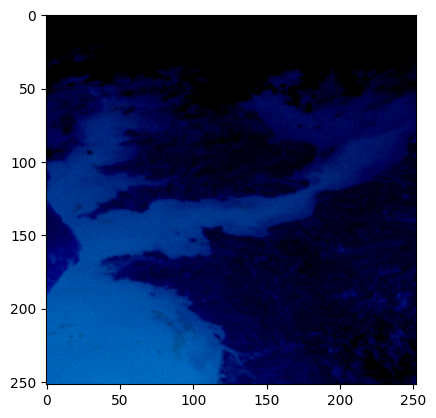

In [110]:
plt.imshow(x.swapaxes(1, 2)[0][0][0:3].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


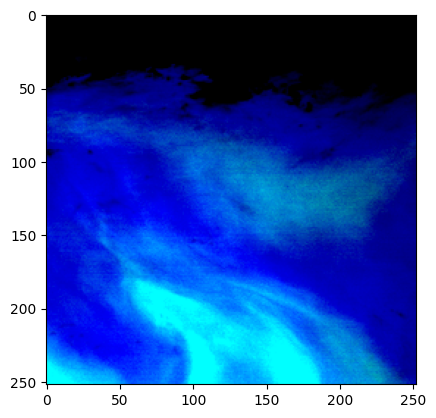

In [113]:
plt.imshow(x.swapaxes(1, 2)[0][0][8:11].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


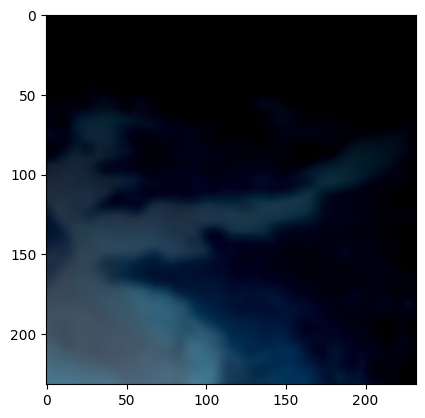

In [109]:
plt.imshow(concat[0][1].permute(1, 2, 0))

In [337]:
custom_res_net = ResNetEmbedder()

In [338]:
res = custom_res_net(x)
res.shape

torch.Size([1, 4, 1, 256, 256])

In [123]:
resnet.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
)